# **Fera Formidável 4.14**

* Caio M. C. Ruas - RM: 24010

## Introdução

### *Objetivo*

O objetivo dessa fera é, dado uma base de dados com elementos e seus custos, encontrar uma liga de três elementos que tenha o maior custo possível e o menor peso atômico possível. Essa liga ternária deve ser da forma xA.y B.z C, onde x, y e z são as quantidades dos elementos A, B e C, respectivamente, e a soma de x, y e z deve ser igual a 100 g. Além disso, cada elemento deve ter uma quantidade mínima de 5 g.

Para atender esse objetivo, utilizaremos um algoritmo genético. A ideia é que cada indivíduo da população represente uma liga ternária, e o algoritmo irá evoluir essa população ao longo de várias gerações. Para atender às restrições, ao invés de penalizar no fitness, vamos garantir que as ligas geradas atendam às restrições de quantidade mínima e soma total.

### *Contexto*

Essa Fera é muito interessante, pois ela parece muito com a Fera Formidável 4.13, mas com a adição de mais um objetivo: minimizar o peso atômico da liga. Pode parecer pouco, mas isso torna o problema muito mais complexo e interessante. Para resolver esse problema, primeiro precisamos entender o que implica termos mais de um objetivo.

Como dito anteriormente, na fera anterior havia apenas um objetivo: maximizar o custo da liga. Isso significa que, para cada indivíduo, tínhamos uma única medida de qualidade, o que facilitava a avaliação e comparação entre os indivíduos. Inclusive, era possível ter uma solução teórica simples, que era pegar o elemento com maior custo e fazer uma liga em que ele fosse o elemento majoritário, ou seja, com 90 g, e os outros dois elementos com 5 g cada. No entanto, agora que temos dois objetivos, teremos duas medidas de qualidade, portanto não podemos fazer uma simples escolha do elemento com maior custo, pois isso pode levar a uma liga com um peso atômico muito alto.

Isso nos leva a outro problema: como avaliar um indivíduo considerando duas medidas diferentes? A resposta é que não podemos, pelo menos não de forma direta.

Então, precisamos de uma abordagem diferente. Uma forma de lidar com múltiplos objetivos é usar o conceito de **frente de Pareto**. A ideia é que, ao invés de tentar maximizar ou minimizar uma única medida, vamos tentar encontrar um conjunto de soluções que sejam "boas" em relação a ambos os objetivos. Essas soluções formam a frente de Pareto, que é o conjunto de soluções que não podem ser melhoradas em um objetivo sem piorar o outro.

Para entender melhor, vamos considerar um exemplo simples. Suponha que temos três ligas, A, B e C, com os seguintes custos e pesos atômicos:

<div class="cell markdown">
<center>

| Liga | Custo (R$) | Peso Atômico (g/mol) |
|------|------------|-----------------------|
| A    | 100        | 50                    |
| B    | 90         | 60                    |
| C    | 80         | 30                    |
</center>

Comparando os três percebemos o seguinte:
- A liga A é melhor que B em ambos os objetivos, pois tem um custo maior e um peso atômico menor. Porém não é possível entender qual a melhor liga entre A e C, pois A é melhor em custo, mas C é melhor em peso atômico.
- A liga B é pior que A em ambos os objetivos. Porém, é melhor que C em custo, mas pior em peso atômico.
- A liga C é melhor que A e B em peso atômico, mas pior em custo pra ambas.

Pensemos em uma pessoa que queira fazer uma liga. Se ela priorizar o custo, ela escolherá a liga A, pois é a melhor em custo. Mas se ela priorizar o peso atômico, ela escolherá a liga C, pois é a melhor nesse aspecto. Por fim, mesmo que uma pessoa queira uma liga que esteja no meio termo, B não seria uma boa escolha pois é pior que A em ambos objetivos. Nesse cenário, dizemos que a liga B é **dominada** por A, pois não há razão para escolher B ao invés de A.

A **frente de Pareto** é o conjunto de soluções que não são dominadas por outras soluções. No nosso exemplo, a frente de Pareto seria composta pelas ligas A e C, pois elas não são dominadas por nenhuma outra liga.

### *E o código?*

Concluindo, agora que entendemos o que é a frente de Pareto, podemos implementar um algoritmo genético para resolver o problema da liga ternária. O algoritmo irá evoluir uma população de ligas, selecionando as melhores ligas em relação aos dois objetivos (não dominadas), cruzando e mutando essas ligas para gerar novas ligas, e assim por diante. Ao final do processo, teremos um conjunto de ligas que formam a frente de Pareto, ou seja, as melhores ligas em relação aos dois objetivos.

Implementar esse algoritmo em python puro é um pouco trabalhoso, mesmo sendo possível. Felizmente, existem bibliotecas que facilitam esse processo, como o `DEAP` (Distributed Evolutionary Algorithms in Python). Nessa biblioteca, podemos encontrar um operador de seleção denominado `NSGA2`, que é um algoritmo genético multiobjetivo que utiliza o conceito de frente de Pareto para selecionar os melhores indivíduos da população. E é exatamente o que iremos utilizar nessa fera.

## Bibliotecas e definições iniciais

Nessa célula, importamos as bibliotecas necessárias e definimos a base de dados com os elementos e seus custos. Também definimos algumas variáveis que delimitam as condições do problema, como a quantidade mínima de cada elemento e o máximo da liga.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Importando as ferramentas do DEAP
from deap import base, creator, tools, algorithms

random.seed(8)
np.random.seed(8)

preco = {
    "H": 1.39, "He": 24, "Li": 85.6, "Be": 857, "B": 3.68, "C": 0.122,
    "N": 0.14, "O": 0.154, "F": 2.16, "Ne": 240, "Na": 3.43, "Mg": 2.32,
    "Al": 1.79, "Si": 1.7, "P": 2.69, "S": 0.0926, "Cl": 0.082, "Ar": 0.931,
    "K": 13.6, "Ca": 2.35, "Sc": 3460, "Ti": 11.7, "V": 385, "Cr": 9.4,
    "Mn": 1.82, "Fe": 0.424, "Co": 32.8, "Ni": 13.9, "Cu": 6, "Zn": 2.55,
    "Ga": 148, "Ge": 1010, "As": 1.31, "Se": 21.4, "Br": 4.39, "Kr": 290,
    "Rb": 15500, "Sr": 6.68, "Y": 31, "Nb": 85.6, "Mo": 40.1, "Tc": 100000,
    "Ru": 10600, "Rh": 147000, "Pd": 49500, "Ag": 521, "Cd": 2.73, "In": 167,
    "Sn": 18.7, "Sb": 5.79, "Te": 63.5, "I": 35, "Xe": 1800, "Cs": 61800,
    "Ba": 0.275, "La": 4.92, "Ce": 4.71, "Pr": 103, "Nd": 57.5, "Pm": 460000,
    "Sm": 13.9, "Eu": 31.4, "Gd": 28.6, "Tb": 658, "Dy": 307, "Ho": 57.1,
    "Er": 26.4, "Tm": 3000, "Yb": 17.1, "Lu": 643, "Hf": 900, "Ta": 312,
    "W": 35.3, "Re": 4150, "Os": 12000, "Ir": 56200, "Pt": 27800, "Hg": 30.2,
    "Tl": 4200, "Pb": 2, "Bi": 6.36, "Po": 49200000000000, "Ac": 29000000000000,
    "Th": 287, "Pa": 280000, "U": 101, "Np": 660000, "Pu": 6490000,
    "Am": 750000, "Cm": 160000000000, "Bk": 185000000000, "Cf": 185000000000
}
peso_atomico = {
    "H": 1.008, "He": 4.002602, "Li": 6.94, "Be": 9.0121831, "B": 10.81,
    "C": 12.011, "N": 14.007, "O": 15.999, "F": 18.998403163, "Ne": 20.1797,
    "Na": 22.98976928, "Mg": 24.305, "Al": 26.9815385, "Si": 28.085,
    "P": 30.973761998, "S": 32.06, "Cl": 35.45, "Ar": 39.948, "K": 39.0983,
    "Ca": 40.078, "Sc": 44.955908, "Ti": 47.867, "V": 50.9415, "Cr": 51.9961,
    "Mn": 54.938044, "Fe": 55.845, "Co": 58.933194, "Ni": 58.6934,
    "Cu": 63.546, "Zn": 65.38, "Ga": 69.723, "Ge": 72.63, "As": 74.921595,
    "Se": 78.971, "Br": 79.904, "Kr": 83.798, "Rb": 85.4678, "Sr": 87.62,
    "Y": 88.90584, "Nb": 92.90637, "Mo": 95.95, "Tc": 97.90721, "Ru": 101.07,
    "Rh": 102.9055, "Pd": 106.42, "Ag": 107.8682, "Cd": 112.414, "In": 114.818,
    "Sn": 118.71, "Sb": 121.76, "Te": 127.6, "I": 126.90447, "Xe": 131.293,
    "Cs": 132.90545196, "Ba": 137.327, "La": 138.90547, "Ce": 140.116,
    "Pr": 140.90766, "Nd": 144.242, "Pm": 144.91276, "Sm": 150.36,
    "Eu": 151.964, "Gd": 157.25, "Tb": 158.92535, "Dy": 162.5,
    "Ho": 164.93033, "Er": 167.259, "Tm": 168.93422, "Yb": 173.045,
    "Lu": 174.9668, "Hf": 178.49, "Ta": 180.94788, "W": 183.84,
    "Re": 186.207, "Os": 190.23, "Ir": 192.217, "Pt": 195.084,
    "Hg": 200.592, "Tl": 204.38, "Pb": 207.2, "Bi": 208.9804, "Po": 209.0,
    "Ac": 227.0, "Th": 232.0377, "Pa": 231.03588, "U": 238.02891,
    "Np": 237.0, "Pu": 244.0, "Am": 243.0, "Cm": 247.0, "Bk": 247.0,
    "Cf": 251.0
}
TODOS_ELEMENTOS_DISPONIVEIS = list(preco.keys())
NUM_ELEMENTOS_LIGA = 3
MASSA_TOTAL_G = 100.0
MASSA_MINIMA_POR_ELEMENTO_G = 5.0

## Funções auxiliares

Aqui, definimos as funções auxiliares para o problema: Uma função responsável por garantir que as massas sejam válidas e as funções que geram indivíduos e calculam o custo e o peso atômico de uma liga.

In [2]:
# --- FUNÇÕES DE GERAÇÃO E OPERADORES ---

def _gerar_massas_validas():
    """
    Função auxiliar para gerar 3 massas que somam 100g, com cada uma sendo >= 5g.
    """
    massa_restante = MASSA_TOTAL_G - NUM_ELEMENTOS_LIGA * MASSA_MINIMA_POR_ELEMENTO_G
    
    ponto1 = random.uniform(0, massa_restante)
    ponto2 = random.uniform(0, massa_restante)
    
    cortes = sorted([0, ponto1, ponto2, massa_restante])
    
    massa_adicional_1 = cortes[1] - cortes[0]
    massa_adicional_2 = cortes[2] - cortes[1]
    massa_adicional_3 = cortes[3] - cortes[2]
    
    massas = [
        round(MASSA_MINIMA_POR_ELEMENTO_G + massa_adicional_1, 2),
        round(MASSA_MINIMA_POR_ELEMENTO_G + massa_adicional_2, 2),
        round(MASSA_MINIMA_POR_ELEMENTO_G + massa_adicional_3, 2),
    ]
    
    massas[0] += MASSA_TOTAL_G - sum(massas)
    
    random.shuffle(massas)
    return massas

def cria_candidato_liga():
    """
    Cria um candidato para a liga garantindo elementos únicos e massas válidas.
    """
    elementos = random.sample(TODOS_ELEMENTOS_DISPONIVEIS, NUM_ELEMENTOS_LIGA)

    massas = _gerar_massas_validas()

    candidato = list(zip(elementos, massas))
    return candidato

def avalia_candidato_liga(candidato):
    """
    Avalia um candidato da liga, retornando o custo total e a soma dos pesos atômicos.
    O custo total é a soma do preço de cada elemento multiplicado pela sua massa (em kg).
    A soma dos pesos atômicos é a soma dos pesos atômicos de cada elemento.
    """
    # Objetivo 1: Custo Total (queremos maximizar)
    custo_total = sum(preco.get(elem, 0) * (massa_g / 1000.0) for elem, massa_g in candidato)

    # Objetivo 2: Soma dos Pesos Atômicos (queremos minimizar)
    peso_atomico_combinado = sum(peso_atomico.get(e, 0) for e, m in candidato)

    return custo_total, peso_atomico_combinado

## Operadores do algoritmo genético

Aqui, definimos os operadores de cruzamento e mutação do algoritmo genético. Novamente, o operador de seleção será o `NSGA2`, que será definido na célula de execução do algoritmo.

In [3]:
def cruzamento_liga(ind1, ind2):
    """
    Realiza o cruzamento de ponto simples de forma a garantir sempre um filho válido.
    """
    elementos_pai1 = {gene[0] for gene in ind1}
    elementos_pai2 = {gene[0] for gene in ind2}
    pool_de_elementos = sorted(list(elementos_pai1.union(elementos_pai2)))
    
    while len(pool_de_elementos) < NUM_ELEMENTOS_LIGA:
        novo_elemento = random.choice(TODOS_ELEMENTOS_DISPONIVEIS)
        if novo_elemento not in pool_de_elementos:
            pool_de_elementos.append(novo_elemento)
            
    elementos_filho1 = random.sample(pool_de_elementos, NUM_ELEMENTOS_LIGA)
    massas_filho1 = _gerar_massas_validas()
    filho1 = creator.Individual(zip(elementos_filho1, massas_filho1))

    elementos_filho2 = random.sample(pool_de_elementos, NUM_ELEMENTOS_LIGA)
    massas_filho2 = _gerar_massas_validas()
    filho2 = creator.Individual(zip(elementos_filho2, massas_filho2))

    return filho1, filho2

def mutacao_liga(candidato):
    """
    Realiza a mutação de forma a garantir sempre um candidato válido.
    Temos duas possíveis mutações:
    1. Trocar um elemento.
    2. Reajustar as massas.
    """
    if random.random() < 0.5:
        indice_mutacao = random.randint(0, len(candidato) - 1)
        elementos_atuais = {gene[0] for gene in candidato}
        
        novo_elemento = random.choice(TODOS_ELEMENTOS_DISPONIVEIS)
        while novo_elemento in elementos_atuais:
            novo_elemento = random.choice(TODOS_ELEMENTOS_DISPONIVEIS)
        
        candidato[indice_mutacao] = (novo_elemento, candidato[indice_mutacao][1])
    else:
        elementos_atuais = [gene[0] for gene in candidato]
        novas_massas = _gerar_massas_validas()
        for i in range(len(candidato)):
            candidato[i] = (elementos_atuais[i], novas_massas[i])
            
    return candidato,

## Aplicando o algoritmo genético

Nessa etapa, juntamos as funções definidas anteriormente para estruturar e aplicar a função do algoritmo genético em sí. Então, definimos os parâmetros do algoritmo, como a população inicial, o número de gerações e a taxa de mutação. Em seguida, aplicamos o algoritmo e exibimos os resultados.

Esta etapa do código, que é mais diferente (no sentido de aplicação nova), terá mais comentários explicativos, para que fique mais claro o que está acontecendo. Aqui que definimos o `NSGA2`.

In [4]:
# --- CONFIGURAÇÃO DO DEAP ---

# 1. Definindo a Estrutura de Fitness e Indivíduo
# MAXIMIZAR o custo (peso 1.0) e MINIMIZAR o peso atômico (peso -1.0)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# 2. Configurando a Caixa de Ferramentas (Toolbox)
toolbox = base.Toolbox()

# Registrando nossas funções personalizadas
toolbox.register("individual", tools.initIterate, creator.Individual, cria_candidato_liga)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", avalia_candidato_liga)
toolbox.register("mate", cruzamento_liga)
toolbox.register("mutate", mutacao_liga)
toolbox.register("select", tools.selNSGA2) # NSGA-II!

Com ele configurado, podemos executar.

In [5]:
# --- EXECUÇÃO DO ALGORITMO NSGA-II ---

# Parâmetros do Algoritmo
POP_SIZE = 150
MAX_GENERATIONS = 750
CX_PROB = 0.9  # Probabilidade de Crossover
MUT_PROB = 0.2 # Probabilidade de Mutação

# Criação da população inicial
pop = toolbox.population(n=POP_SIZE)

# "Hall of Fame" para guardar a fronteira de Pareto
pareto_front = tools.ParetoFront()

# Avaliação inicial dos indivíduos
fitnesses = toolbox.map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Atualiza o hall of fame com a população inicial
pareto_front.update(pop)

print(f"Geração 0: {len(pareto_front)} soluções na fronteira.")

# Loop das gerações
for gen in range(1, MAX_GENERATIONS + 1):
    # Seleção e criação da próxima geração (filhos)
    offspring = algorithms.varAnd(pop, toolbox, CX_PROB, MUT_PROB)

    # Avalia os filhos que foram modificados
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Seleção da nova população (pais + filhos) para a próxima geração
    pop = toolbox.select(pop + offspring, POP_SIZE)
    
    # Atualiza o hall of fame com a nova população
    pareto_front.update(pop)
    
    if gen % 25 == 0:
        print(f"Geração {gen}: {len(pareto_front)} soluções na fronteira.")

print("\n--- Fim da Execução ---")
print(f"A Fronteira de Pareto final contém {len(pareto_front)} soluções não-dominadas.")

Geração 0: 9 soluções na fronteira.
Geração 25: 22 soluções na fronteira.
Geração 50: 25 soluções na fronteira.
Geração 75: 23 soluções na fronteira.
Geração 100: 22 soluções na fronteira.
Geração 125: 23 soluções na fronteira.
Geração 150: 20 soluções na fronteira.
Geração 175: 21 soluções na fronteira.
Geração 200: 26 soluções na fronteira.
Geração 225: 28 soluções na fronteira.
Geração 250: 28 soluções na fronteira.
Geração 275: 29 soluções na fronteira.
Geração 300: 32 soluções na fronteira.
Geração 325: 32 soluções na fronteira.
Geração 350: 32 soluções na fronteira.
Geração 375: 33 soluções na fronteira.
Geração 400: 34 soluções na fronteira.
Geração 425: 32 soluções na fronteira.
Geração 450: 32 soluções na fronteira.
Geração 475: 34 soluções na fronteira.
Geração 500: 34 soluções na fronteira.
Geração 525: 34 soluções na fronteira.
Geração 550: 37 soluções na fronteira.
Geração 575: 37 soluções na fronteira.
Geração 600: 38 soluções na fronteira.
Geração 625: 39 soluções na fro

Que legal! Tivemos 42 soluções na fronteira, agora podemos entender mais graficamente esse resultado!!


Exemplos de ligas na Fronteira de Pareto:
  Solução 1: Custo $4,558,754,150,000.00 | Peso Atômico Total 683.00
    - Po: 89.52g
    - Bk: 5.19g
    - Ac: 5.29g
  Solução 2: Custo $4,557,794,033,683.10 | Peso Atômico Total 680.00
    - Po: 89.52g
    - Pu: 5.19g
    - Ac: 5.29g
  Solução 3: Custo $4,557,794,001,453.20 | Peso Atômico Total 667.04
    - Po: 89.52g
    - Pa: 5.19g
    - Ac: 5.29g
  Solução 4: Custo $4,557,794,000,762.93 | Peso Atômico Total 538.91
    - Po: 89.52g
    - Rh: 5.19g
    - Ac: 5.29g
  Solução 5: Custo $4,557,794,000,005.24 | Peso Atômico Total 508.63
    - Po: 89.52g
    - Ge: 5.19g
    - Ac: 5.29g


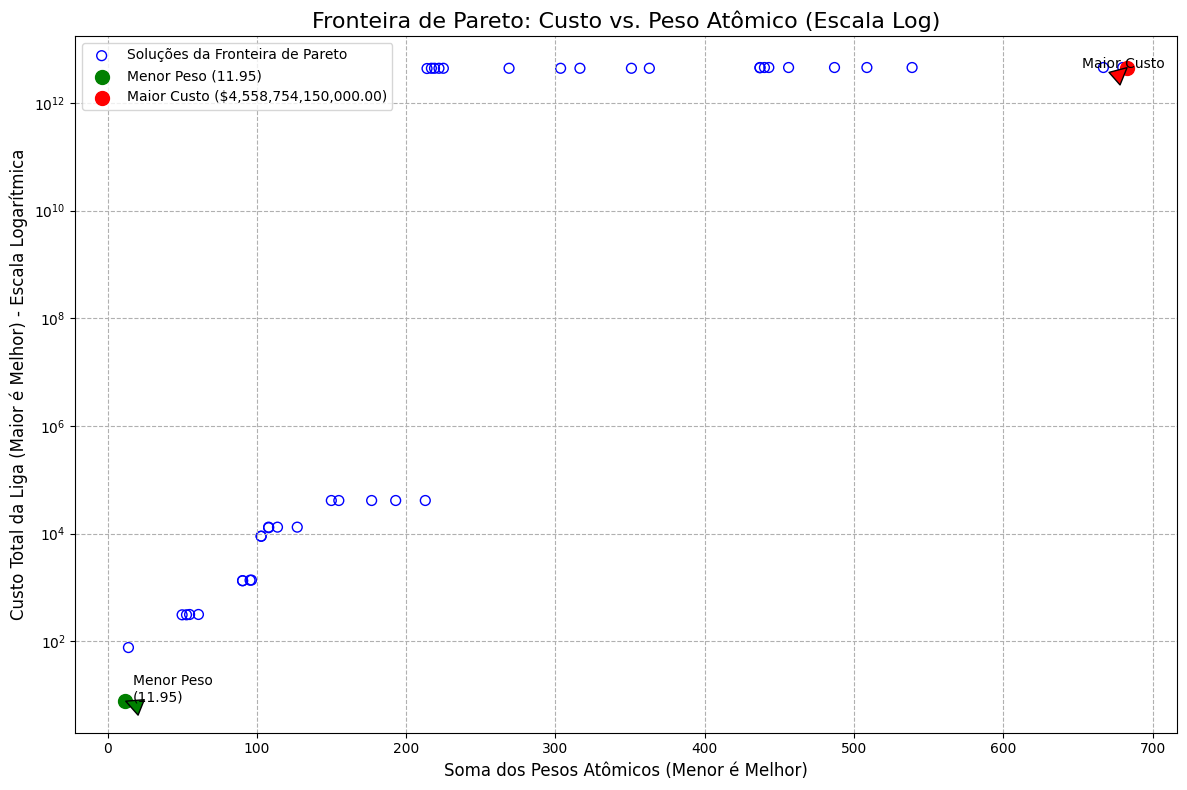

In [ ]:
# --- RESULTADOS FINAIS ---

# Imprime algumas das melhores soluções encontradas
print("\nExemplos de ligas na Fronteira de Pareto:")
for i, sol in enumerate(pareto_front[:5]): # Mostra as 5 primeiras
    custo, peso = sol.fitness.values
    print(f"  Solução {i+1}: Custo ${custo:,.2f} | Peso Atômico Total {peso:.2f}")
    for elem, massa in sol:
        print(f"    - {elem}: {massa:.2f}g")


# --- GRÁFICO DA FRONTEIRA DE PARETO ---
# Dados extraídos
custos = [sol.fitness.values[0] for sol in pareto_front]
pesos = [sol.fitness.values[1] for sol in pareto_front]

# Criando a figura para o gráfico
plt.figure(figsize=(12, 8))

# Plotando os dados da Fronteira de Pareto
plt.scatter(pesos, custos, facecolors='none', edgecolors='blue', label='Soluções da Fronteira de Pareto', s=50)

# Aplicando a escala logarítmica no eixo Y (Custo)
plt.yscale('log')

# 1. Encontrar e destacar os pontos extremos
# Ponto de Menor Peso
min_peso_idx = np.argmin(pesos)
max_custo_em_min_peso = custos[min_peso_idx]
min_peso = pesos[min_peso_idx]
plt.scatter(min_peso, max_custo_em_min_peso, color='green', s=100, label=f'Menor Peso ({min_peso:.2f})')
plt.annotate(f'Menor Peso\n({min_peso:.2f})', 
             xy=(min_peso, max_custo_em_min_peso), 
             xytext=(min_peso + 5, max_custo_em_min_peso),
             arrowprops=dict(facecolor='green', shrink=0.05))

# Ponto de Maior Custo
max_custo_idx = np.argmax(custos)
peso_em_max_custo = pesos[max_custo_idx]
max_custo = custos[max_custo_idx]
plt.scatter(peso_em_max_custo, max_custo, color='red', s=100, label=f'Maior Custo (${max_custo:,.2f})')
plt.annotate(f'Maior Custo', 
             xy=(peso_em_max_custo, max_custo), 
             xytext=(peso_em_max_custo - 30, max_custo),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title("Fronteira de Pareto: Custo vs. Peso Atômico (Escala Log)", fontsize=16)
plt.xlabel("Soma dos Pesos Atômicos (Menor é Melhor)", fontsize=12)
plt.ylabel("Custo Total da Liga (Maior é Melhor) - Escala Logarítmica", fontsize=12)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()

Como podemos observar pelo gráfico, tem duas distribuições bem distintas de soluções. Isso parece fazer muito sentido, pois temos dois objetivos bem distintos e com proporções bem diferentes.

## Conclusão

Não foi possível encontrar uma solução única para o problema, mas por conta do seu próprio design. Então, o que conseguimos foi encontrar um conjunto de soluções que formam a frente de Pareto, ou seja, as melhores ligas em relação aos dois objetivos.
Isso é muito interessante, pois mostra que o problema é complexo e que há várias soluções possíveis, cada uma com suas vantagens e desvantagens. 

Além disso, o uso do algoritmo genético e do operador de seleção `NSGA2` foi fundamental para encontrar essas soluções.

## Referências

$^{[1]}$ SHARIFI, M. R. et al. A new optimization algorithm to solve multi-objective problems. Scientific Reports, v. 11, n. 1, 13 out. 2021. 

$^{[2]}$ YANG, C.; YE, W.; LI, Q. Review of the performance optimization of parallel manipulators. Mechanism and machine theory, v. 170, p. 104725–104725, 1 abr. 2022.  

$^{[3]}$ Evolutionary Tools — DEAP 1.4.3 documentation. Disponível em: <https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA2>. Acesso em: 12 jun. 2025. 